# **Modlee Example**

Training a model and fine-tuning it's loop is an important part of training deep learning models. In this example code we will be using modlee trainer and making our own custom training loop.

We will be using one of the assessment examples to setup our sample classification data and design a custom CNN model. Our task here is to learn how to specify optimizers and learning rates to help model learn better.

In this task we will be using the:
- Adagrad optimizer
- Rampup learning rate

## Setup

We specify our modlee API key and other attributes to setup our enviroment for the classification task. We will use `D_B_L_E=525406252164` a image classification problem. As the task requires us to have a model footprint of `20 mb` we won't be using a set of pretrained model weights. 

In [1]:
# Set your API key
import os
#simulate setting environment variable
os.environ['MODLEE_API_KEY'] = "UGRbxzsAqXNg5CR26gHLQKYL0lsGsCj2"
#set local variable to environment variable
api_key = os.environ['MODLEE_API_KEY']
#assert api_key != "UGRbxzsAqXNg5CR26gHLQKYL0lsGsCj2", "Please update the placeholder for your Modlee Purple API key. See above Installation instructions."

# Install packages from a requirements file, a workaround for Colab
'''!curl -H X-API-KEY:$MODLEE_API_KEY https://server.modlee.ai:7070/get_wheel/requirements.txt -O
!pip3 install -r requirements.txt

# Install modlee packages
!pip3 install --no-deps modlee modlee-onnx2torch modlee-onnx_graphsurgeon \
    lightning==2.0.7 pytorch-lightning==2.0.7 lightning-utilities lightning-cloud torchmetrics==1.3.2'''

'!curl -H X-API-KEY:$MODLEE_API_KEY https://server.modlee.ai:7070/get_wheel/requirements.txt -O\n!pip3 install -r requirements.txt\n\n# Install modlee packages\n!pip3 install --no-deps modlee modlee-onnx2torch modlee-onnx_graphsurgeon     lightning==2.0.7 pytorch-lightning==2.0.7 lightning-utilities lightning-cloud torchmetrics==1.3.2'

In [2]:
%load_ext autoreload
%autoreload 2

import os,zipfile,shutil,requests

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.jit as jit
import torch.nn.functional as F

import numpy as np

import lightning.pytorch as pl
import modlee
from modlee.recommender import from_modality_task as trainer_for_modality_task


/home/tarush/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Exercise Setup

Here we specify variables for the modlee API

In [3]:

exercise_id = "D_B_L_E=525406252164"
exercise_modality = "image"
exercise_task = "classification"
model_size_restriction_MB = 20

# assert exercise_id != "replace-with-your-exercise-id", "Please update the placeholder for your Modlee Exercise ID. See above Installation instructions."
# assert exercise_modality != "replace-with-your-modality", "Please update the placeholder for your Modlee Exercise ID. See above Installation instructions."
# assert exercise_task != "replace-with-your-exercise-task", "Please update the placeholder for your Modlee Exercise Task. See above Installation instructions."
# assert model_size_restriction_MB != "replace-with-your-model_size_restriction_MB", "Please update the placeholder for your Modlee Exercise model_size_restriction_MB. See above Installation instructions."


## Dataset Setup

**Please do not make changes to the following cell**

For the machine learning task we will be downloading the necessary files and setup the API key. 

In [4]:

root_url = 'http://ubuntu@ec2-3-93-170-96.compute-1.amazonaws.com:5000'
url = f"{root_url}/get-interview-utils"  # Change the port if your Flask app is running on a different one
response = requests.get(url, params={'api_key': api_key,'exercise_id':exercise_id})

# Check if the request was successful
if response.status_code == 200:
    # Write the content of the response (the file) to a new file in binary mode
    with open('interview_utils.py', 'wb') as f:
        f.write(response.content)
    print(f"File downloaded successfully: interview_utils.py")
else:
    print(f"Failed to download file: {response.status_code} {response.reason}")

from interview_utils import *
from interview_utils import ModleeImageClassifier,setup,submit

unzip_train_dataloader,unzip_val_dataloader,example_batch_images = setup(api_key,exercise_id)

modlee.init(api_key=api_key)


File downloaded successfully: interview_utils.py
File downloaded successfully: ./modlee_interview_data/modlee_interview_data.zip


### Custom Convolutional Neural Network (CustomCNN2)

The `CustomCNN2` class defines a convolutional neural network (CNN) in PyTorch, designed for classification tasks. Here's a simple explanation of the code:

#### Imports

The necessary PyTorch modules and functions are imported to build and train the neural network.

#### Class Definition

The `CustomCNN2` class inherits from `nn.Module`, the base class for all neural network modules in PyTorch.

#### Initialization (`__init__` method)

- **Activation Functions:** Sets up internal and final activation functions based on user input (`relu`, `leaky_relu`, `sigmoid`, or `tanh`).
- **Convolutional Layers:** 
  - Layer 1: Two convolutional layers with 64 filters, batch normalization, and dropout.
  - Layer 2: Two convolutional layers with 128 filters, batch normalization, and dropout.
  - Layer 3: Two convolutional layers with 256 filters, batch normalization, and dropout.
  - Layer 4: One convolutional layer with 512 filters, batch normalization, and dropout.
- **Pooling Layer:** A max pooling layer to reduce the spatial dimensions.
- **Fully Connected Layers:**
  - First fully connected layer with 1024 units, batch normalization, and dropout.
  - Second fully connected layer that outputs the final class scores.

#### Weight Initialization

The `_initialize_weights` method initializes the weights of the network layers using appropriate initialization methods (e.g., `kaiming_normal_` for convolutional layers).

#### Activation Function Getter

The `_get_activation` method returns the appropriate activation function based on the input string.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
import torch.nn.init as init
import torchvision.models as models
from torch.nn import Transformer
from torch.utils.data import Dataset




class CustomCNN2(nn.Module):
    def __init__(self, num_classes, internal_activation='leaky_relu', final_activation='leaky_relu'):
        super(CustomCNN2, self).__init__()

        # Store activation functions
        self.internal_activation = self._get_activation(internal_activation)
        self.final_activation = self._get_activation(final_activation)

        # Layer 1: Two convolutional layers with 64 filters
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.dropout1_1 = nn.Dropout2d(0.2)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.dropout1_2 = nn.Dropout2d(0.2)

        # Layer 2: Two convolutional layers with 128 filters
        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.dropout2_1 = nn.Dropout2d(0.2)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.dropout2_2 = nn.Dropout2d(0.2)

        # Layer 3: Two convolutional layers with 256 filters
        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.dropout3_1 = nn.Dropout2d(0.2)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.dropout3_2 = nn.Dropout2d(0.2)

        # Layer 4: One convolutional layer with 512 filters
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.dropout4 = nn.Dropout2d(0.2)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.dropout_fc1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(1024, num_classes)

        # Weight initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, 0, 0.01)
                init.constant_(m.bias, 0)

    def _get_activation(self, activation):
        if activation == 'relu':
            return F.relu
        elif activation == 'leaky_relu':
            return F.leaky_relu
        elif activation == 'sigmoid':
            return torch.sigmoid
        elif activation == 'tanh':
            return torch.tanh
        else:
            raise ValueError(f"Unsupported activation: {activation}")

    def forward(self, x):
        # Layer 1
        x = self.dropout1_1(self.internal_activation(self.bn1_1(self.conv1_1(x))))
        x = self.dropout1_2(self.internal_activation(self.bn1_2(self.conv1_2(x))))
        x = self.pool(x)

        # Layer 2
        x = self.dropout2_1(self.internal_activation(self.bn2_1(self.conv2_1(x))))
        x = self.dropout2_2(self.internal_activation(self.bn2_2(self.conv2_2(x))))
        x = self.pool(x)

        # Layer 3
        x = self.dropout3_1(self.internal_activation(self.bn3_1(self.conv3_1(x))))
        x = self.dropout3_2(self.internal_activation(self.bn3_2(self.conv3_2(x))))
        x = self.pool(x)

        # Layer 4
        x = self.dropout4(self.internal_activation(self.bn4(self.conv4(x))))
        x = self.pool(x)

        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.dropout_fc1(self.final_activation(self.fc1(x)))
        x = self.fc2(x)
        return x

model = CustomCNN2(unzip_train_dataloader.dataset.num_classes)


### ModleeCustomCNN Class

The `ModleeCustomCNN` class is a custom model built on top of a base class from the `modlee` package. This class integrates a custom CNN model and specifies the training and validation steps, as well as the optimizer and learning rate scheduler.

#### Class Definition

The `ModleeCustomCNN` class inherits from `modlee.model.ModleeModel`. In the `__init__` method, the custom CNN model and the loss function (`cross_entropy`) are initialized.

#### Forward Method

The `forward` method defines the forward pass of the model, which simply passes the input `x` through the custom CNN model.

#### Training Step

The `training_step` method takes a batch of training data, performs a forward pass to get the predictions, calculates the loss using the specified loss function, and returns it.

#### Validation Step

The `validation_step` method operates on validation data, calculates, and returns the validation loss.

#### Optimizers and Learning Rate Schedulers

The `configure_optimizers` method defines the optimizer and learning rate scheduler:
- **Optimizer:** Uses `Adagrad` with a learning rate of 0.01.
- **Learning Rate Scheduler:** Uses `LambdaLR` to adjust the learning rate based on the epoch. The `lr_lambda` function ramps up the learning rate for the first 2 epochs and keeps it constant afterward.

#### Model Instantiation

An instance of the `ModleeCustomCNN` model is created with the number of classes from the dataset.

#### Class Distribution Visualization

This code snippet counts and visualizes the distribution of classes in the dataset using `Counter` and `matplotlib`. It prints the class distribution and optionally plots a bar chart showing the count of each class.

Number of classes:  31
Class Distribution:


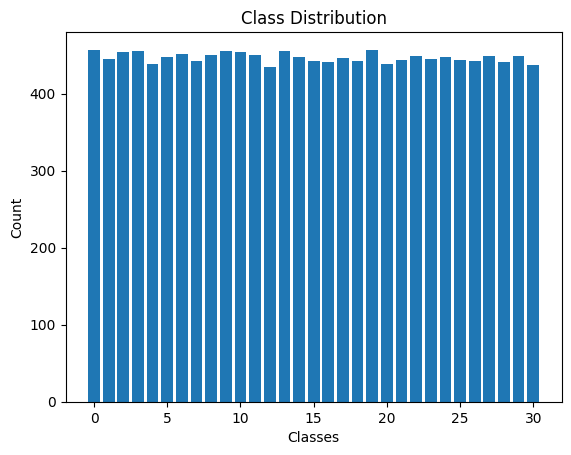

In [34]:
class ModleeCustomCNN(modlee.model.ModleeModel):
    def __init__(self, num_classes):
        super(ModleeCustomCNN, self).__init__()
        self.model = model
        self.loss_fn = F.cross_entropy

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y_target = batch
        y_pred = self(x)
        loss = self.loss_fn(y_pred, y_target)
        return {"loss": loss}

    def validation_step(self, val_batch, batch_idx):
        x, y_target = val_batch
        y_pred = self(x)
        val_loss = self.loss_fn(y_pred, y_target)
        return {'val_loss': val_loss}

    def configure_optimizers(self):
        optimizer = optim.Adagrad(self.parameters(), lr=0.01)
        #optimizer = optim.Adam(self.parameters(), lr=0.01)

        def lr_lambda(epoch):
            rampup_epochs = 2
            if epoch < rampup_epochs:
                return float(epoch) / float(max(1, rampup_epochs))
            return 1.0

        scheduler = LambdaLR(optimizer, lr_lambda)
        #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
        #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
        return [optimizer], [scheduler]
    
    
modlee_model = ModleeCustomCNN(unzip_train_dataloader.dataset.num_classes)

print("Number of classes: ", unzip_train_dataloader.dataset.num_classes)

from collections import Counter
import matplotlib.pyplot as plt

# Assuming unzip_train_dataloader is your DataLoader
labels = [label for _, label in unzip_train_dataloader.dataset]

# Count the occurrences of each label
label_counts = Counter(labels)

# Print the distribution of classes and their count
print("Class Distribution:")

# Optional: Plot the distribution
classes, counts = zip(*label_counts.items())
plt.bar(classes, counts)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

## Explanation

**MLflow End Run:** Ends any active MLflow run to ensure a clean start for the new training session.

**Trainer Initialization:**
- **trainer_for_modality_task:** Initializes a trainer object configured for a specific modality (like image, text, etc.) and task (classification, regression, etc.).

**Data Loader Assignment:**
- `trainer.dataloader = unzip_train_dataloader` assigns your training data loader (`unzip_train_dataloader`) to the trainer.

**Model Assignment:**
- `trainer.model = modlee_model` assigns your custom CNN model (`modlee_model`) to the trainer for training.

**Training:**
- `trainer.train(max_epochs=180, val_dataloaders=unzip_val_dataloader)` starts the training process for 180 epochs using the training data loader (`unzip_train_dataloader`) and validation data loader (`unzip_val_dataloader`).

In [35]:
modlee.mlflow.end_run()

trainer = trainer_for_modality_task(
    modality=exercise_modality,
    task=exercise_task,
    )

trainer.dataloader = unzip_train_dataloader
trainer.model = modlee_model
print(trainer.model)
trainer.train(max_epochs=180, val_dataloaders=unzip_val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


ModleeCustomCNN(
  (model): CustomCNN2(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1_1): Dropout2d(p=0.2, inplace=False)
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1_2): Dropout2d(p=0.2, inplace=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2_1): Dropout2d(p=0.2, inplace=False)
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2_2): Dropout2d(p=0.2, inplace=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

INFO:Logging data metafeatures...
INFO:Logging model as code (model_graph.py) and text (model_graph.txt)...


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 3.434


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.378 >= min_delta = 0.0. New best score: 2.056


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.257 >= min_delta = 0.0. New best score: 1.799


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.197 >= min_delta = 0.0. New best score: 1.602


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.085 >= min_delta = 0.0. New best score: 1.517


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.132 >= min_delta = 0.0. New best score: 1.385


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.365


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.069 >= min_delta = 0.0. New best score: 1.296


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 1.266


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 1.208


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 1.166


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.0. New best score: 1.142


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.131


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.121


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 1.056


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.017


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.005


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.989


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.975


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.948


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.942


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.919


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.893


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.884


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.866


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.861


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.860


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.851


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.844


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.843


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.838


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.833


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.830


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.817


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.817. Signaling Trainer to stop.


### Metrics

We perfrom simple metric evaluation of the model. We will use the confusion matrix to map out the classification accuracy per class allowing a better understanding of where the model is having an issue. For this we will be generating a classifciation report and checking the heatmap of the classification. 

**evaluate_model** : We define a method to evaluate and pass our test set to the model. 

We use this `evaluate_model` method to:
- Get model accuracy
- Get confusion matrix for F-1 score, precision and recall
- Plot the heatmap of class distribution 


Accuracy: 0.72


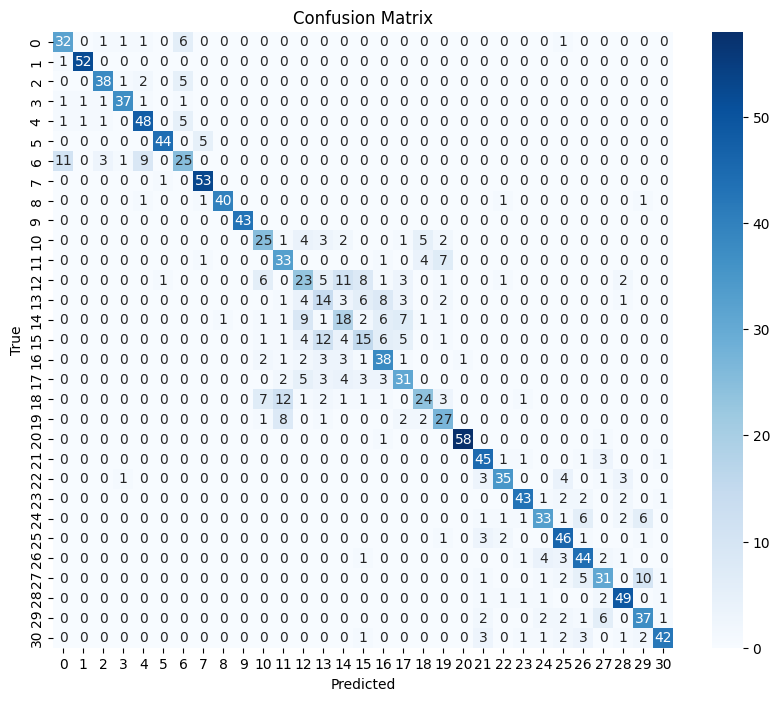

              precision    recall  f1-score   support

           0       0.70      0.76      0.73        42
           1       0.96      0.98      0.97        53
           2       0.86      0.83      0.84        46
           3       0.90      0.88      0.89        42
           4       0.77      0.86      0.81        56
           5       0.96      0.90      0.93        49
           6       0.60      0.51      0.55        49
           7       0.88      0.98      0.93        54
           8       0.98      0.91      0.94        44
           9       1.00      1.00      1.00        43
          10       0.58      0.58      0.58        43
          11       0.55      0.72      0.62        46
          12       0.44      0.37      0.40        62
          13       0.32      0.33      0.33        42
          14       0.39      0.38      0.38        48
          15       0.39      0.31      0.34        49
          16       0.58      0.73      0.65        52
          17       0.58    

In [37]:
### we print out the accuracy of the model on validation set and plot the confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for x, y in dataloader:
            y_true.extend(y.numpy())
            y_pred.extend(torch.argmax(model(x), dim=1).numpy())
    return y_true, y_pred

y_true, y_pred = evaluate_model(modlee_model, unzip_val_dataloader)

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### we also print out the f1 and recall scores
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))


### Classification Report

The classification report provides a detailed evaluation of the `modlee_model` performance on the validation dataset (`unzip_val_dataloader`).

- **Precision:** Precision measures the accuracy of positive predictions. For example, for class 0, the precision is 0.70, indicating that 70% of instances predicted as class 0 are actually correct.

- **Recall:** Recall measures the fraction of actual positives that are correctly identified by the model. A recall of 0.76 for class 0 means that the model correctly identifies 76% of all actual instances of class 0.

- **F1-score:** The F1-score is the harmonic mean of precision and recall, providing a single metric that balances both measures. For class 0, the F1-score is 0.73.

- **Support:** Indicates the number of samples for each class in the true dataset. For instance, there are 42 samples of class 0 in the validation dataset.

- **Accuracy:** Overall accuracy of the model across all classes, calculated as 0.72, indicates that the model correctly predicts 72% of the samples in the validation dataset.

This report is useful for understanding the model's performance on individual classes and overall, providing insights into where it excels and where it may struggle in classification tasks.